In [6]:
!pip install tensorflow keras split-folders opencv-python

In [50]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import splitfolders
import cv2
import os
import random
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras import layers, models

In [28]:
input_folder = '/Users/e4ekhan/Hackathon/Pics'
output_folder = '/Users/e4ekhan/Hackathon/ImageRecognition'

split_ratio = (0.8, 0.1, 0.1)

splitfolders.ratio(
    input_folder,
    output = output_folder,
    seed = 500,
    ratio = split_ratio,
    group_prefix = None
)

Copying files: 4677 files [00:07, 642.62 files/s]


In [34]:
# Define the parameters
img_size = (224, 224)
batch_size = 32

train_datagen = ImageDataGenerator(
    preprocessing_function = preprocess_input,
    rotation_range = 20,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest'
)

In [36]:
# Data augmentation for test data (only rescaling)
test_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)
# Data augmentation for validation data (only rescaling)
valid_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)

In [46]:
train_dir = os.path.join(output_folder, 'train')
val_dir = os.path.join(output_folder, 'val')
test_dir = os.path.join(output_folder, 'test')

train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size = img_size,
    batch_size = batch_size,
    class_mode = 'categorical'
)

test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size = img_size,
    batch_size = batch_size,
    class_mode = 'categorical'
)

valid_data = valid_datagen.flow_from_directory(
    val_dir,
    target_size = img_size,
    batch_size = batch_size,
    class_mode = 'categorical'
)

Found 3741 images belonging to 4 classes.
Found 469 images belonging to 4 classes.
Found 467 images belonging to 4 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-119.68..151.061].


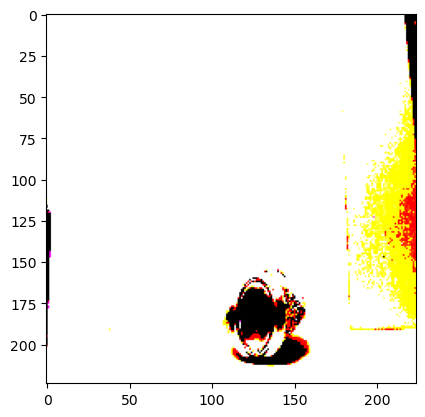

In [52]:
# Get a batch of images and labels
images, labels = next(valid_data)

# Select a random image from the batch
idx = random.randint(0, images.shape[0] - 1)

# Display the image
plt.imshow(images[idx])
plt.show()

In [54]:
from keras.applications.resnet import ResNet50
base_model = ResNet50(weights = 'imagenet', include_top = False, input_shape = (img_size[0], img_size[1], 3))

# Freeze the convolutional base
base_model.trainable = False

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 154s 2us/step


In [70]:
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation = 'relu'),
    layers.Dropout(0.5),
    layers.Dense(4, activation = 'softmax')
])

In [74]:
model.compile(optimizer = 'adam',
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

In [78]:
model.fit(train_data, epochs = 10, validation_data = valid_data)

Epoch 1/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 278s 2s/step - accuracy: 0.9452 - loss: 0.1436 - val_accuracy: 0.9636 - val_loss: 0.0929
Epoch 2/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 276s 2s/step - accuracy: 0.9599 - loss: 0.1067 - val_accuracy: 0.9786 - val_loss: 0.0568
Epoch 3/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 276s 2s/step - accuracy: 0.9661 - loss: 0.0896 - val_accuracy: 0.9850 - val_loss: 0.0468
Epoch 4/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 275s 2s/step - accuracy: 0.9751 - loss: 0.0772 - val_accuracy: 0.9850 - val_loss: 0.0335
Epoch 5/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 269s 2s/step - accuracy: 0.9706 - loss: 0.0809 - val_accuracy: 0.9893 - val_loss: 0.0376
Epoch 6/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 278s 2s/step - accuracy: 0.9706 - loss: 0.0754 - val_accuracy: 0.9850 - val_loss: 0.0457
Epoch 7/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 273s 2s/step - accuracy: 0.9788 - loss: 0.0531 - val_accuracy: 0.9936 - val_loss: 0.0231
Epoch 8/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 273s 2s/step - accuracy: 0.9792 - loss: 0.0529 - val_accu

In [84]:
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_data)

print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

15/15 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.9841 - loss: 0.0449
Test Accuracy: 98.51%


In [86]:
class_names = {0: 'Can', 1: 'Glass', 2: 'Paper', 3: 'Plastic'}

In [94]:
def predict_img(image, model):
    test_img = cv2.imread(image)
    test_img = cv2.resize(test_img,(224,224))
    test_img = np.expand_dims(test_img, axis = 0)
    result = model.predict(test_img)
    r = np.argmax(result)
    print(class_names[r])

In [96]:
predict_img('/Users/e4ekhan/Downloads/test.png', model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Can


In [98]:
predict_img('/Users/e4ekhan/Downloads/test2.jpg', model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
Glass


In [100]:
model.save('CropModel.keras')